# Tuning Neural Networks with Keras Tuner

STEP 1: INSTALL REQUIRED LIBRARIES

 TensorFlow is the main library for deep learning.
 keras-tuner helps us automatically find the best hyperparameters for our model.
 If you don't have them installed, run this command in Jupyter Notebook or Colab:

In [1]:
!pip install tensorflow keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.8 MB/s eta 0:00:00


STEP 2: IMPORT NECESSARY LIBRARIES

In [2]:
import tensorflow as tf  # Import the TensorFlow library
from tensorflow import keras  # Import Keras (a high-level API for TensorFlow)
from tensorflow.keras import layers  # Import layers to build our neural network
import keras_tuner as kt  # Import Keras Tuner for hyperparameter tuning

import numpy as np  # Used for numerical operations
import matplotlib.pyplot as plt  # Used to plot graphs

 STEP 3: LOAD & PREPROCESS MNIST DATASET


 The MNIST dataset consists of 70,000 images of handwritten digits (0-9)
 These are grayscale images of size 28x28 pixels.

 Load dataset directly from Keras (it will automatically download if not available)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1 (this helps the model learn better)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Neural networks expect images to have a "channel" dimension (e.g., grayscale has 1 channel).
# Our dataset has shape (60000, 28, 28), but we need (60000, 28, 28, 1).
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
# Let's print the shape to confirm
print("Training data shape:", x_train.shape)  # Expected: (60000, 28, 28, 1)
print("Test data shape:", x_test.shape)  # Expected: (10000, 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


STEP 4: DEFINE A MODEL FOR HYPERPARAMETER TUNING

In deep learning, choosing the right settings (e.g., number of neurons, learning rate) can be tricky. Instead of guessing, we use Keras Tuner to automatically find the best ones.

In [4]:
# This function builds a Convolutional Neural Network (CNN) model and lets us tune hyperparameters
def build_model(hp):  # 'hp' stands for hyperparameters
    model = keras.Sequential()  # Create a sequential (layer-by-layer) model

    # First convolutional layer (extracts patterns from images)
    # We let Keras Tuner decide whether to use 32 or 64 filters
    model.add(layers.Conv2D(
        filters=hp.Choice('conv1_filters', values=[32, 64]),
        kernel_size=(3,3),  # 3x3 filter size
        activation='relu',   # ReLU activation makes training more efficient
        input_shape=(28, 28, 1)  # Input shape: 28x28 images with 1 color channel
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  # Reduces image size to avoid overfitting

    # Second convolutional layer (extracts more detailed patterns)
    model.add(layers.Conv2D(
        filters=hp.Choice('conv2_filters', values=[32, 64]),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  # Again, reduces size for efficiency

    model.add(layers.Flatten())  # Flattens 2D images into a 1D array for the dense layer

    # Fully connected (dense) layer with tunable dropout to reduce overfitting
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.3, step=0.1)))

    # Output layer - 10 neurons (one for each digit 0-9), using softmax to get probabilities
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.001, 0.0005])),
        loss='sparse_categorical_crossentropy',  # Loss function for classification
        metrics=['accuracy']  # Track accuracy during training
    )

    print("Model built with hyperparameters:", hp.values)  # Debugging print statement
    return model


 STEP 5: RUN KERAS TUNER TO FIND BEST HYPERPARAMETERS

 Keras Tuner will try different hyperparameter combinations and find the best one.

In [5]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # We want to maximize validation accuracy
    max_trials=5,  # Try 5 different sets of hyperparameters
    executions_per_trial=1,  # Run each model once (increase for stability)
    directory='kt_mnist',  # Directory where results are stored
    project_name='mnist_cnn'  # Name of the tuning project
)

# Stop training early if validation loss stops improving (prevents unnecessary training)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Start the tuning process (this will take some time)
print("Starting hyperparameter tuning...")
tuner.search(x_train, y_train, epochs=3, validation_split=0.2, callbacks=[early_stopping])

Trial 5 Complete [00h 01m 55s]
val_accuracy: 0.9862499833106995

Best val_accuracy So Far: 0.9879999756813049
Total elapsed time: 00h 12m 56s


 STEP 6: RETRIEVE AND TRAIN THE BEST MODEL

In [6]:
# Once tuning is complete, we get the best hyperparameter combination found.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters Found: {best_hps.values}")

# Build the best model using these hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model using the best hyperparameters
print("Training final model with best hyperparameters...")
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Best Hyperparameters Found: {'conv1_filters': 32, 'conv2_filters': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Model built with hyperparameters: {'conv1_filters': 32, 'conv2_filters': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Training final model with best hyperparameters...
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.8823 - loss: 0.3723 - val_accuracy: 0.9835 - val_loss: 0.0467
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - accuracy: 0.9786 - loss: 0.0698 - val_accuracy: 0.9877 - val_loss: 0.0358
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 28ms/step - accuracy: 0.9864 - loss: 0.0466 - val_accuracy: 0.9887 - val_loss: 0.0333


STEP 7: PLOT TRAINING LOSS BEFORE AND AFTER TUNING

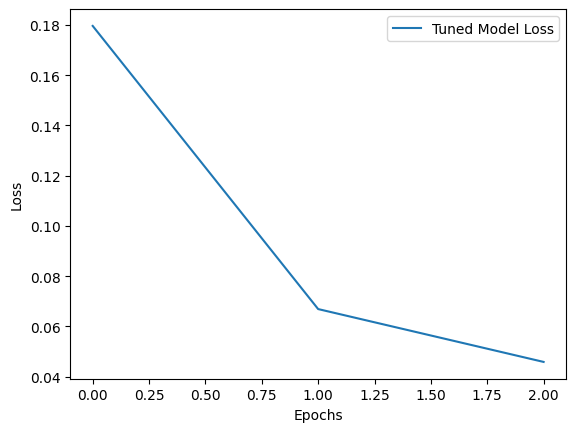

In [7]:
# This graph shows how well the model is learning over time.
plt.plot(history.history['loss'], label='Tuned Model Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()
plt.show()

STEP 8: EVALUATE THE FINAL MODEL ON TEST DATA

In [8]:

# Now that training is done, let's see how well our model performs on real test images.

loss, accuracy = model.evaluate(x_test, y_test)  # Evaluate the model
print(f'Tuned Model Accuracy: {accuracy * 100:.2f}%')  # Print accuracy as a percentage


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9859 - loss: 0.0427
Tuned Model Accuracy: 98.87%
